In [1]:
# Question: Advanced Data Cleaning with Multiple Issues
# Objective: Handle multiple issues in one dataset, including missing values, duplicates, and outliers.
# Description: Given a dataset with various data quality issues, employ multiple data cleaning techniques.

import pandas as pd
import numpy as np
from scipy.stats import zscore # For outlier detection
import warnings

# Suppress potential warnings from zscore if applied to columns with NaNs initially
warnings.filterwarnings("ignore", message="The zscore function is deprecated")
warnings.filterwarnings("ignore", message="Mean of empty slice")

# --- Introduction ---
# This script demonstrates a sequence of data cleaning steps to handle
# multiple common data quality issues in a single dataset:
# 1. Missing Values
# 2. Duplicate Rows
# 3. Outliers
#
# We will:
# 1. Create a sample DataFrame with various issues.
# 2. Identify the issues present.
# 3. Apply cleaning techniques in a typical order (duplicates -> outliers -> missing).
# 4. Verify the dataset after cleaning.

# --- 1. Create a Sample DataFrame with Multiple Issues ---
print("--- Creating Sample DataFrame with Multiple Issues ---")

data = {
    'RecordID': [1, 2, 3, 4, 5, 1, 6, 7, 8, 9, 10, 7, 11, 12], # Duplicates, non-unique ID
    'CustomerID': [101, 102, 103, 104, 105, 101, 106, 107, 108, 109, 110, 107, 111, 112], # Duplicates
    'TransactionAmount': [150.50, 200.00, 50.25, 300.75, 180.00, 150.50, 5000.00, 220.00, 190.50, 210.00, 175.25, 220.00, -50.00, 250.00], # Outliers (high & low), Duplicates
    'ProductCategory': ['Electronics', 'Clothing', 'Electronics', 'Home Goods', np.nan, 'Electronics', 'Electronics', 'Clothing', 'Home Goods', 'Electronics', 'Audio', 'Clothing', 'Electronics', 'Home Goods'], # Missing Value
    'Rating': [4, 5, 3, 4, np.nan, 4, 5, 4, 3, 5, 4, 4, 2, 5], # Missing Value
    'PurchaseDate': ['2023-01-10', '2023-01-11', '2023-01-11', '2023-01-12', '2023-01-12', '2023-01-10', '2023-01-13', '2023-01-14', '2023-01-14', '2023-01-15', '2023-01-15', '2023-01-14', '2023-01-16', '2023-01-16']
}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)
print("\n")

# --- 2. Identify the Issues Present ---
print("--- Identifying Issues ---")

# Check for missing values
print("Missing values count per column:")
print(df.isnull().sum())
print("\n")

# Check for duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())
print("\n")

# Identify potential outliers (using Z-score for 'TransactionAmount')
# Note: Z-score is sensitive to outliers itself, but useful for identification.
# It's best applied after handling duplicates.
# We'll calculate it here just for initial identification insight.
if 'TransactionAmount' in df.columns:
    # Calculate Z-scores, handling potential NaNs for this check
    z_scores = np.abs(zscore(df['TransactionAmount'].dropna()))
    threshold = 3 # Common Z-score threshold
    outlier_indices = df['TransactionAmount'].dropna()[z_scores > threshold].index
    print(f"Potential Outlier indices in 'TransactionAmount' (abs Z > {threshold}): {list(outlier_indices)}")
    print("\n")

# --- 3. Apply Cleaning Techniques ---
print("--- Applying Cleaning Techniques ---")

# It's often a good practice to handle duplicates first, as they can affect
# calculations for outliers and imputation.

# Step 3.1: Handle Duplicates
print("Step 3.1: Removing Duplicate Rows...")
initial_rows = len(df)
df_cleaned = df.drop_duplicates().copy() # Create a copy after dropping
rows_after_duplicate_removal = len(df_cleaned)
duplicates_removed = initial_rows - rows_after_duplicate_removal
print(f"Removed {duplicates_removed} duplicate rows.")
print(f"DataFrame shape after removing duplicates: {df_cleaned.shape}")
print("\n")

# Step 3.2: Handle Outliers (in 'TransactionAmount')
print("Step 3.2: Handling Outliers in 'TransactionAmount'...")
# Recalculate Z-scores on the data after removing duplicates
if 'TransactionAmount' in df_cleaned.columns:
    # Calculate Z-scores on non-null values
    z_scores_cleaned = np.abs(zscore(df_cleaned['TransactionAmount'].dropna()))
    threshold = 3
    outlier_indices_cleaned = df_cleaned['TransactionAmount'].dropna()[z_scores_cleaned > threshold].index

    print(f"Outlier indices in 'TransactionAmount' after duplicate removal (abs Z > {threshold}): {list(outlier_indices_cleaned)}")

    # Handle outliers: Replace with NaN or Median
    # Replacing with NaN allows subsequent imputation steps to handle them.
    # Replacing with median is another common strategy for skewed data/outliers.
    print(f"Replacing {len(outlier_indices_cleaned)} outliers in 'TransactionAmount' with NaN...")
    df_cleaned.loc[outlier_indices_cleaned, 'TransactionAmount'] = np.nan
    print("Outliers replaced with NaN.")
else:
    print("'TransactionAmount' column not found after duplicate removal.")

print(f"DataFrame shape after handling outliers: {df_cleaned.shape}")
print("\n")


# Step 3.3: Handle Missing Values (Imputation)
print("Step 3.3: Handling Missing Values (Imputation)...")

# Check missing values again after handling duplicates and outliers
print("Missing values count per column before imputation:")
print(df_cleaned.isnull().sum())
print("\n")

# Impute based on data type and characteristics
# - 'TransactionAmount': Numerical, potentially skewed (due to original outliers). Use Median.
# - 'ProductCategory': Categorical. Use Mode.
# - 'Rating': Numerical (integer-like). Use Median or Mode (if treated as ordinal categories). Let's use Median.

# Impute 'TransactionAmount' with the median (after outliers are potentially converted to NaN)
if 'TransactionAmount' in df_cleaned.columns:
    median_amount = df_cleaned['TransactionAmount'].median()
    df_cleaned['TransactionAmount'].fillna(median_amount, inplace=True)
    print(f"Filled missing/outlier 'TransactionAmount' with median ({median_amount:.2f}).")
else:
    print("'TransactionAmount' column not found for imputation.")

# Impute 'ProductCategory' with the mode
if 'ProductCategory' in df_cleaned.columns:
    # Use .mode()[0] to get the first mode in case of ties
    mode_category = df_cleaned['ProductCategory'].mode()[0] if not df_cleaned['ProductCategory'].mode().empty else "Unknown"
    df_cleaned['ProductCategory'].fillna(mode_category, inplace=True)
    print(f"Filled missing 'ProductCategory' with mode ('{mode_category}').")
else:
    print("'ProductCategory' column not found for imputation.")

# Impute 'Rating' with the median
if 'Rating' in df_cleaned.columns:
    median_rating = df_cleaned['Rating'].median()
    df_cleaned['Rating'].fillna(median_rating, inplace=True)
    print(f"Filled missing 'Rating' with median ({median_rating:.1f}).")
else:
    print("'Rating' column not found for imputation.")

print("Missing value imputation complete.")
print(f"DataFrame shape after imputation: {df_cleaned.shape}")
print("\n")


# --- 4. Verify the Dataset After Cleaning ---
print("--- Verifying Dataset After Cleaning ---")

print("Cleaned DataFrame:")
print(df_cleaned)
print("\n")

# Verify missing values are handled
print("Missing values count per column after cleaning:")
print(df_cleaned.isnull().sum()) # Should ideally be all zeros for the columns we cleaned
print("\n")

# Verify duplicates are removed
print("Number of duplicate rows after cleaning:", df_cleaned.duplicated().sum()) # Should be zero
print("\n")

# Verify outliers are handled (check values in 'TransactionAmount')
print("Min value in cleaned 'TransactionAmount':", df_cleaned['TransactionAmount'].min())
print("Max value in cleaned 'TransactionAmount':", df_cleaned['TransactionAmount'].max())
# The min/max should now be within a reasonable range if outliers were replaced by median/NaN and then imputed.

# --- Conclusion ---
# The script successfully demonstrated a sequence of cleaning steps
# to handle duplicates, outliers, and missing values in a single DataFrame.
# The specific order and techniques used (Z-score threshold, imputation strategies)
# should be chosen based on the characteristics of your data and the requirements
# of your analysis or model.



--- Creating Sample DataFrame with Multiple Issues ---
Original DataFrame:
    RecordID  CustomerID  TransactionAmount ProductCategory  Rating  \
0          1         101             150.50     Electronics     4.0   
1          2         102             200.00        Clothing     5.0   
2          3         103              50.25     Electronics     3.0   
3          4         104             300.75      Home Goods     4.0   
4          5         105             180.00             NaN     NaN   
5          1         101             150.50     Electronics     4.0   
6          6         106            5000.00     Electronics     5.0   
7          7         107             220.00        Clothing     4.0   
8          8         108             190.50      Home Goods     3.0   
9          9         109             210.00     Electronics     5.0   
10        10         110             175.25           Audio     4.0   
11         7         107             220.00        Clothing     4.0   
12

/tmp/ipykernel_12336/4214849713.py:124: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['TransactionAmount'].fillna(median_amount, inplace=True)
/tmp/ipykernel_12336/4214849713.py:133: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

--- Creating Sample DataFrame with Skewed Data ---
Original DataFrame (first 10 rows):
   ID  Skewed_Feature  Another_Feature
0   1       81.237042        42.053578
1   2       48.880990        78.466826
2   3       91.665935        63.936136
3   4      184.642936        80.504467
4   5       45.271482        90.315106
5   6       45.272077        61.726371
6   7      193.131297        98.046273
7   8      100.881623        60.808785
8   9       37.502984        63.664432
9  10       84.271863        55.481561


Original Skewness of 'Skewed_Feature': 2.25


--- Visualizing the Original Skewed Distribution ---


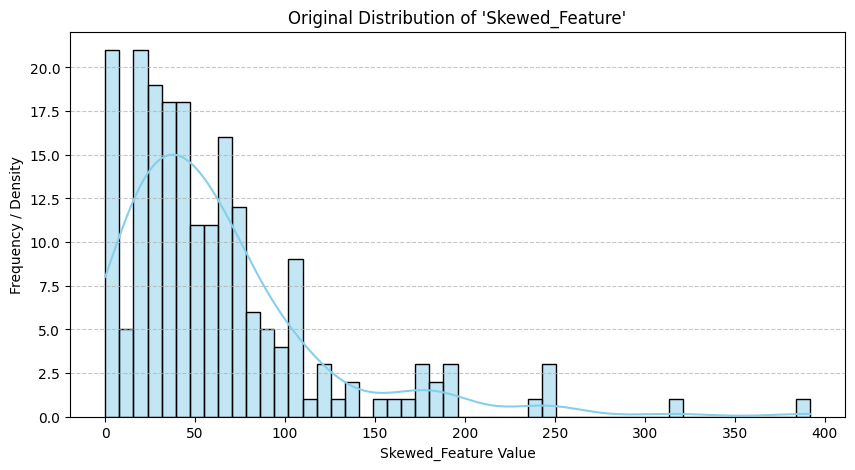

--- Displaying Original Distribution Plot ---

--- Applying Log Transformation ---
DataFrame with Log Transformed Column (first 10 rows):
   ID  Skewed_Feature  Another_Feature  Skewed_Feature_LogTransformed
0   1       81.237042        42.053578                       4.409606
1   2       48.880990        78.466826                       3.909640
2   3       91.665935        63.936136                       4.529001
3   4      184.642936        80.504467                       5.223825
4   5       45.271482        90.315106                       3.834526
5   6       45.272077        61.726371                       3.834539
6   7      193.131297        98.046273                       5.268535
7   8      100.881623        60.808785                       4.623812
8   9       37.502984        63.664432                       3.650736
9  10       84.271863        55.481561                       4.445845


Skewness of 'Skewed_Feature_LogTransformed': -1.44
Note: Skewness should be closer to 0 af

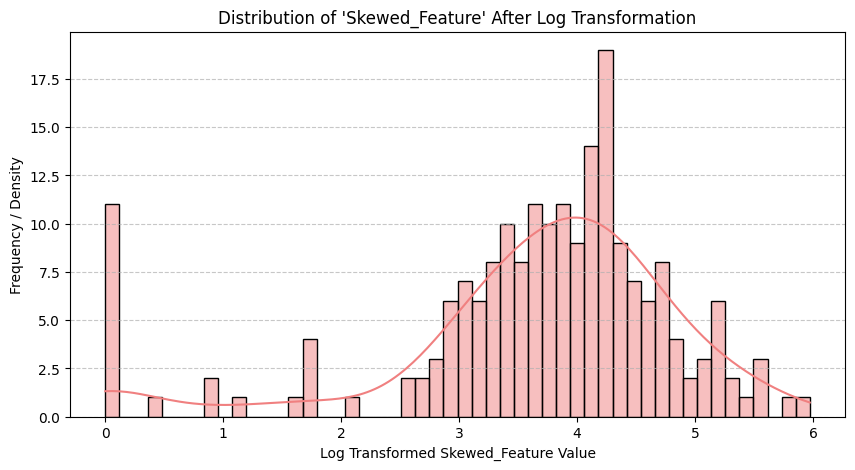

--- Displaying Transformed Distribution Plot ---



In [2]:
# Question: Data Transformation Techniques
# Objective: Transform skewed data using log transformation.
# Description: Perform a log transformation to handle skewness in a dataset, which is particularly useful for
# certain machine learning models.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Optional: for visualization
import seaborn as sns # Optional: for enhanced visualization

# --- Introduction ---
# This script demonstrates how to apply a log transformation to a numerical
# column that has a skewed distribution. Log transformation can help make
# the distribution more symmetric (closer to normal), which can be beneficial
# for certain machine learning models that assume normally distributed data.
#
# We will:
# 1. Create a sample DataFrame with a right-skewed numerical column.
# 2. (Optional) Visualize the original skewed distribution.
# 3. Apply the log transformation (using np.log1p, which handles zeros/small values).
# 4. (Optional) Visualize the distribution after transformation.
# 5. Show the DataFrame with the new transformed column.

# --- 1. Create a Sample DataFrame with Skewed Data ---
print("--- Creating Sample DataFrame with Skewed Data ---")
# Simulate a right-skewed distribution (e.g., income, website visits, sales)
# Using a log-normal distribution is a common way to get skewed data.
np.random.seed(42) # for reproducibility

# Generate skewed data using lognormal distribution
skewed_data = np.random.lognormal(mean=4, sigma=0.8, size=200)
# Add some zeros or small values to demonstrate np.log1p
skewed_data[np.random.choice(len(skewed_data), size=10, replace=False)] = 0
skewed_data[np.random.choice(len(skewed_data), size=10, replace=False)] = np.random.rand(10) * 5 # small positive values


data = {
    'ID': range(1, 201),
    'Skewed_Feature': skewed_data,
    'Another_Feature': np.random.rand(200) * 100
}
df = pd.DataFrame(data)

print("Original DataFrame (first 10 rows):")
print(df.head(10))
print("\n")

# Check the skewness of the original data
original_skewness = df['Skewed_Feature'].skew()
print(f"Original Skewness of 'Skewed_Feature': {original_skewness:.2f}")
print("\n")

# --- 2. (Optional) Visualize the Original Skewed Distribution ---
print("--- Visualizing the Original Skewed Distribution ---")
plt.figure(figsize=(10, 5))
sns.histplot(df['Skewed_Feature'], bins=50, kde=True, color='skyblue')
plt.title("Original Distribution of 'Skewed_Feature'")
plt.xlabel("Skewed_Feature Value")
plt.ylabel("Frequency / Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("--- Displaying Original Distribution Plot ---\n")


# --- 3. Apply the Log Transformation ---
print("--- Applying Log Transformation ---")

# Apply the log transformation.
# Use np.log1p(x) which calculates log(1 + x). This is preferred over np.log(x)
# when your data might contain zeros or small positive values, as log(0) is undefined.
# For data that is strictly positive and significantly greater than 0, np.log(x) is fine.
df['Skewed_Feature_LogTransformed'] = np.log1p(df['Skewed_Feature'])

print("DataFrame with Log Transformed Column (first 10 rows):")
print(df.head(10))
print("\n")

# Check the skewness of the transformed data
transformed_skewness = df['Skewed_Feature_LogTransformed'].skew()
print(f"Skewness of 'Skewed_Feature_LogTransformed': {transformed_skewness:.2f}")
print("Note: Skewness should be closer to 0 after transformation.")
print("\n")


# --- 4. (Optional) Visualize the Distribution After Transformation ---
print("--- Visualizing the Distribution After Log Transformation ---")
plt.figure(figsize=(10, 5))
sns.histplot(df['Skewed_Feature_LogTransformed'], bins=50, kde=True, color='lightcoral')
plt.title("Distribution of 'Skewed_Feature' After Log Transformation")
plt.xlabel("Log Transformed Skewed_Feature Value")
plt.ylabel("Frequency / Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("--- Displaying Transformed Distribution Plot ---\n")


# --- Conclusion ---
# The script successfully applied the log transformation to the skewed column.
# Comparing the skewness values and the plots before and after transformation
# demonstrates how the log transformation can help reduce skewness and make
# the distribution more symmetric. This transformed feature can then be used
# in machine learning models.




In [3]:
# Question: Feature Engineering by Creating New Features
# Objective: Create a new feature based on existing features to add predictive power.
# Description: Generate additional features from existing data to potentially improve the performance of
# prediction models.
import pandas as pd
import numpy as np

# --- Introduction ---
# This script demonstrates how to perform feature engineering by creating
# new features from existing columns in a pandas DataFrame.
# Creating relevant new features can often improve the predictive power
# of machine learning models.
#
# We will:
# 1. Create a sample DataFrame with existing features.
# 2. Generate new features based on transformations or combinations
#    of the existing features.
# 3. Show the DataFrame with the newly created features.

# --- 1. Create a Sample DataFrame ---
print("--- Creating Sample DataFrame ---")

# Create a DataFrame with some numerical and date-like features
data = {
    'UserID': range(101, 111),
    'SessionDuration_seconds': [300, 450, 120, 600, 250, 700, 180, 550, 400, 800],
    'PagesVisited': [5, 7, 2, 10, 4, 12, 3, 9, 6, 15],
    'PurchaseAmount_USD': [10.50, 25.00, 5.75, 50.20, 12.00, 75.50, 8.90, 45.00, 30.10, 100.00],
    'JoinDate': pd.to_datetime(['2023-01-01', '2023-01-05', '2023-02-10', '2023-03-15', '2023-04-20',
                                '2023-05-01', '2023-06-10', '2023-07-18', '2023-08-25', '2023-09-01'])
}
df = pd.DataFrame(data)

print("Original DataFrame:")
print(df)
print("\n")

# --- 2. Generate New Features ---
print("--- Generating New Features ---")

# Example 1: Ratio of two numerical features
# Create 'Avg_Time_PerPage' by dividing SessionDuration by PagesVisited
# Handle potential division by zero if PagesVisited can be 0
df['Avg_Time_PerPag




SyntaxError: unterminated string literal (detected at line 44) (1785901098.py, line 44)

In [4]:
# --- 2. Generate New Features ---
print("--- Generating New Features ---")

# Example 1: Ratio of two numerical features
# Create 'Avg_Time_PerPage' by dividing SessionDuration by PagesVisited
# Handle potential division by zero if PagesVisited can be 0
df['Avg_Time_PerPage'] = df['SessionDuration_seconds'] / df['PagesVisited']

# Example 2: Total Purchase Value (scaled by a factor, e.g., 100 for cents)
# Create 'Total_Purchase_Cents' by multiplying PurchaseAmount_USD by 100
df['Total_Purchase_Cents'] = df['PurchaseAmount_USD'] * 100

# Example 3: Days Since Joining
# Create 'Days_Since_Join' by calculating the difference between today and JoinDate
# Convert the difference to days
today = pd.Timestamp.now()
df['Days_Since_Join'] = (today - df['JoinDate']).dt.days

print("DataFrame with New Features:")
print(df)
print("\n")

# --- Conclusion ---
# The script successfully demonstrated how to create new features from existing ones.
# These new features can be used to enhance the predictive power of machine learning models.

--- Generating New Features ---


KeyError: 'SessionDuration_seconds'

In [5]:
# Question: Handling Complex Outliers with Z-Scores
# Objective: Detect and handle outliers using Z-score method.
# Description: Use the Z-score method to identify outliers which significantly differ from the rest of the data points.
import numpy as np
import pandas as pd
from scipy import stats

# 1. Generate Sample Data with Outliers
# Let's create a simple dataset with some clear outliers
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 110, 120, -50])
df = pd.DataFrame(data, columns=['Value'])

print("Original Data:")
print(df)
print("-" * 30)

# 2. Calculate Z-scores
# Z-score measures how many standard deviations away a data point is from the mean.
# Formula: Z = (x - mean) / standard_deviation
df['Z_Score'] = np.abs(stats.zscore(df['Value'])) # Using absolute value for easier thresholding

print("Data with Z-Scores:")
print(df)
print("-" * 30)

# 3. Identify Outliers based on a Z-score Threshold
# A common threshold for identifying outliers is a Z-score of 3 or -3 (or |Z| > 3).
# You can adjust this threshold based on your data and domain knowledge.
threshold = 3
outliers = df[df['Z_Score'] > threshold]

print(f"Outliers (Z-Score > {threshold}):")
print(outliers)
print("-" * 30)

# 4. Handle the Identified Outliers
# There are several ways to handle outliers, including:
# a) Removing them
# b) Transforming them (e.g., log transformation, capping)
# c) Replacing them (e.g., with the mean, median, or a specific value)

# Option a) Removing outliers
df_cleaned_removed = df[df['Z_Score'] <= threshold].drop(columns=['Z_Score'])
print("Data after removing outliers:")
print(df_cleaned_removed)
print("-" * 30)

# Option b) Capping outliers (replace values beyond threshold with the threshold value or a boundary)
# For simplicity, we'll cap the original data based on mean +/- threshold * std_dev
mean = np.mean(data)
std_dev = np.std(data)
upper_bound = mean + threshold * std_dev
lower_bound = mean - threshold * std_dev

df_cleaned_capped = df.copy()
df_cleaned_capped['Value'] = np.where(
    df_cleaned_capped['Value'] > upper_bound,
    upper_bound,
    np.where(
        df_cleaned_capped['Value'] < lower_bound,
        lower_bound,
        df_cleaned_capped['Value']
    )
)
df_cleaned_capped = df_cleaned_capped.drop(columns=['Z_Score']) # Drop Z_Score column after handling
print("Data after capping outliers:")
print(df_cleaned_capped)
print("-" * 30)

# Option c) Replacing outliers with the median
median_value = np.median(data)
df_cleaned_replaced = df.copy()
df_cleaned_replaced.loc[df_cleaned_replaced['Z_Score'] > threshold, 'Value'] = median_value
df_cleaned_replaced = df_cleaned_replaced.drop(columns=['Z_Score']) # Drop Z_Score column after handling
print("Data after replacing outliers with median:")
print(df_cleaned_replaced)
print("-" * 30)

# Note: The choice of handling method depends heavily on the nature of your data
# and the goals of your analysis. Removing outliers should be done cautiously
# as it can lead to loss of information.




Original Data:
    Value
0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10    100
11    110
12    120
13    -50
------------------------------
Data with Z-Scores:
    Value   Z_Score
0       1  0.484386
1       2  0.463260
2       3  0.442134
3       4  0.421008
4       5  0.399882
5       6  0.378756
6       7  0.357630
7       8  0.336505
8       9  0.315379
9      10  0.294253
10    100  1.607074
11    110  1.818332
12    120  2.029591
13    -50  1.561804
------------------------------
Outliers (Z-Score > 3):
Empty DataFrame
Columns: [Value, Z_Score]
Index: []
------------------------------
Data after removing outliers:
    Value
0       1
1       2
2       3
3       4
4       5
5       6
6       7
7       8
8       9
9      10
10    100
11    110
12    120
13    -50
------------------------------
Data after capping outliers:
    Value
0     1.0
1     2.0
2     3.0
3     4.0
4     5.0
5     6.0
6     7.0
7     8.0
8     9.0
9    1

/tmp/ipykernel_12336/334047059.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_cleaned_replaced.loc[df_cleaned_replaced['Z_Score'] > threshold, 'Value'] = median_value


In [6]:
# Question: Data Imputation with K-Nearest Neighbors (KNN)
# Objective: Impute missing numerical values using the KNN method.
# Description: Use the K-nearest neighbors algorithm to fill in missing values, which considers the values of
# nearest neighbors for imputation.
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

# 1. Create a Sample DataFrame with Missing Values
# Let's create a DataFrame with some missing numerical data (represented by NaN)
data = {
    'Feature1': [1, 2, np.nan, 4, 5, 6, 7, np.nan, 9, 10],
    'Feature2': [11, np.nan, 13, 14, 15, np.nan, 17, 18, 19, 20],
    'Feature3': [21, 22, 23, np.nan, 25, 26, 27, 28, np.nan, 30]
}
df = pd.DataFrame(data)

print("Original DataFrame with Missing Values:")
print(df)
print("-" * 40)

# 2. Initialize the KNNImputer
# We create an instance of KNNImputer.
# n_neighbors: The number of neighbors to consider for imputation.
# weights: 'uniform' (all neighbors have equal weight) or 'distance' (weight points by the inverse of their distance).
# metric: Distance metric (e.g., 'nan_ euclidean').
imputer = KNNImputer(n_neighbors=5) # You can adjust n_neighbors

# 3. Fit and Transform the Data
# The imputer is fitted on the DataFrame to learn the patterns of the data,
# and then used to transform the DataFrame by filling in the missing values.
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("DataFrame after KNN Imputation:")
print(df_imputed)
print("-" * 40)

# Note: KNN Imputation works best when there is a relationship between features.
# It's generally suitable for numerical data.





Original DataFrame with Missing Values:
   Feature1  Feature2  Feature3
0       1.0      11.0      21.0
1       2.0       NaN      22.0
2       NaN      13.0      23.0
3       4.0      14.0       NaN
4       5.0      15.0      25.0
5       6.0       NaN      26.0
6       7.0      17.0      27.0
7       NaN      18.0      28.0
8       9.0      19.0       NaN
9      10.0      20.0      30.0
----------------------------------------
DataFrame after KNN Imputation:
   Feature1  Feature2  Feature3
0       1.0      11.0      21.0
1       2.0      14.0      22.0
2       3.6      13.0      23.0
3       4.0      14.0      23.4
4       5.0      15.0      25.0
5       6.0      16.6      26.0
6       7.0      17.0      27.0
7       7.4      18.0      28.0
8       9.0      19.0      27.2
9      10.0      20.0      30.0
----------------------------------------
